In [1]:
import Ipynb_importer
import Classic
import Subsetselection
import k2k_hadamard
import timeit

import numpy as np
import random
import math
import matplotlib.pyplot as plt

def generate_geometric_distribution(k,lbd):
    elements = range(0,k)
    prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
    return prob

def generate_uniform_distribution(k):
    raw_distribution = [1] * k
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

def generate_two_steps_distribution(k):
    raw_distribution = [1] * int(k/2) + [3] * int(k/2)
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

def generate_Zipf_distribution(k,lbd):
    raw_distribution = [1/(float(i)**(klbd)) for i in range(1,k+1)]
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

def generate_Dirichlet_distribution(k,lbd):  
    raw_distribution = [0] * k
    for i in range(0,k):
        raw_distribution[i] = np.random.gamma(1,1)
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

importing Jupyter notebook from Classic.ipynb
importing Jupyter notebook from Subsetselection.ipynb
importing Jupyter notebook from k2k_hadamard.ipynb


In [4]:
k = 100 #absz
n = 100000
eps = 1 # privacy_para

# prob = generate_geometric_distribution(k,0.8)
# prob = generate_uniform_distribution(k)
prob = generate_two_steps_distribution(k)
# prob = generate_Zipf_distribution(k,1.0)
# prob = generate_Dirchlet_distribution(k,1.0)

elements = range(0,k)
in_list = np.random.choice(elements, n, p=prob) #input symbols

('l1 distance: ', '0.437829326343')
('prob_sum: ', '1.0')


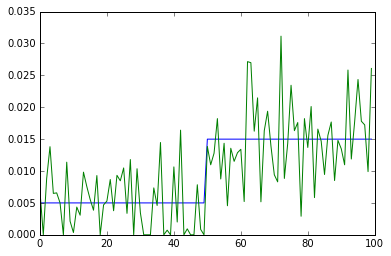

In [5]:
# Subsetselection
a = Subsetselection.Subsetselection(k,eps) 
#print (a.partsz)
#print (elements.type)
# print(type(in_list[9]))
outp = a.encode_string(in_list)
prob_est = a.decode_string(outp,n) # estimate the original underlying distribution
plt.plot(elements,prob)
plt.plot(elements,prob_est)
#plt.plot(prob_est)
print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
print ("prob_sum: ", str(sum(prob_est)))

In [ ]:
# k-rr
sample = Classic.randomized_response_encoder(in_list, eps, k)
(outp, temp) = np.histogram(sample,range(k+1))
#print outp
prob_est = Classic.normalized_standard_rr_decoder(outp,eps,n) # estimate the original underlying distribution
plt.plot(elements,prob)
plt.plot(elements,prob_est)
#plt.plot(prob_est)
print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
print ("prob_sum: ", str(sum(prob_est)))

In [ ]:
# k-rappor
sample = Classic.rappor_encoder(in_list, eps, k)
outp = np.sum(sample, axis=0)
prob_est = Classic.normalized_standard_rappor_decoder(outp,eps,n) # estimate the original underlying distribution
plt.plot(elements,prob)
plt.plot(elements,prob_est)
#plt.plot(prob_est)
print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
print ("prob_sum: ", str(sum(prob_est)))

In [ ]:
b = k2k_hadamard.Hadamard_Rand_2(k,eps) 
#print (a.partsz)
#print (elements.type)
# print(type(in_list[9]))
outp = b.encode_string(in_list)
#print outp
prob_est = b.decode_string(outp) # estimate the original underlying distribution
plt.plot(elements,prob)
plt.plot(elements,prob_est)
#plt.plot(prob_est)
print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
print ("prob_sum: ", str(sum(prob_est)))

In [ ]:
k = 1000 #absz
eps = 1 # privacy_para
a = Subsetselection.Subsetselection(k,eps)
b = k2k_hadamard.Hadamard_Rand_2(k,eps)
#prob = generate_geometric_distribution(k,0.8)

rep = 2
points = 100 
step_sz = 10000
init = 1
indicies = [(init-1+i)*step_sz for i in range(1,points+1) ]

# prob = generate_uniform_distribution(k)
prob = generate_two_steps_distribution(k)
# prob = generate_Zipf_distribution(k,1.0)
# prob = generate_Dirchlet_distribution(k,1.0)
l1_1 = [0]*points
l1_2 = [0]*points
l1_3 = [0]*points
l1_4 = [0]*points

t1_1 = [0]*points
t1_2 = [0]*points
t1_3 = [0]*points
t1_4 = [0]*points

for r in range(init, points + init):
    print(r)
    n = r*step_sz
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    for t in range(0,rep):
        print(t)
        elements = range(0,k)
        in_list = np.random.choice(elements, n, p=prob) #input symbols
        
        outp_1 = a.encode_string(in_list) #subset selection
        start_time = timeit.default_timer()
        prob_est_1 = a.decode_string(outp_1,n) # estimate the original underlying distribution
        t1 = t1 + timeit.default_timer() - start_time
        count1 = count1 + np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est_1)], ord=1)       

        sample = Classic.randomized_response_encoder(in_list, eps, k) # krr
        start_time = timeit.default_timer()
        (outp_2, temp) = np.histogram(sample,range(k+1))
        prob_est_2 = Classic.normalized_standard_rr_decoder(outp_2,eps,n) # estimate the original underlying distribution
        t2 = t2 + timeit.default_timer() - start_time
        count2 = count2 + np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est_2)], ord=1) 
        
        sample = Classic.rappor_encoder(in_list, eps, k) #k-RAPPOR
        start_time = timeit.default_timer()
        outp_3 = np.sum(sample, axis=0)
        prob_est_3 = Classic.normalized_standard_rappor_decoder(outp_3,eps,n) # estimate the original underlying distribution
        t3 = t3 + timeit.default_timer() - start_time
        count3 = count3 + np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est_3)], ord=1) 
        
        outp_4 = b.encode_string(in_list) #k-HR
        start_time = timeit.default_timer()
        prob_est_4 = b.decode_string2(outp_4) # estimate the original underlying distribution
        t4 = t4 + timeit.default_timer() - start_time
        count4 = count4 + np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est_4)], ord=1) 
        
    l1_1[r-1] = count1/float(rep)
    l1_2[r-1] = count2/float(rep)
    l1_3[r-1] = count3/float(rep)
    l1_4[r-1] = count4/float(rep)
    t1_1[r-1] = t1/float(rep)
    t1_2[r-1] = t2/float(rep)
    t1_3[r-1] = t3/float(rep)
    t1_4[r-1] = t4/float(rep)
plt.plot(l1_1, label = 'subset')
plt.plot(l1_2, label = 'rr')
plt.plot(l1_3, label = 'rappor')
plt.plot(l1_4, label = 'hr')
plt.legend()

In [ ]:
plt.plot(l1_1[50:100], label = 'subset')
plt.plot(l1_2[50:100], label = 'rr')
plt.plot(l1_3[50:100], label = 'rappor')
plt.plot(l1_4[50:100], label = 'hr')
plt.legend()

In [ ]:
print(count1)
print(count2)
print(count3)
print(count4)
print(t1)
print(t2)
print(t3)
print(t4)
l1_1

In [ ]:
plt.plot(t1_1[1:100], label = 'subset')
plt.plot(t1_2[1:100], label = 'rr')
plt.plot(t1_3[1:100], label = 'rappor')
plt.plot(t1_4[1:100], label = 'hr')
plt.legend()